In [1]:
%matplotlib widget
import numpy as np
import obspy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import datetime
import types
import pickle
from location.compute_backazimuths import compute_backazimuths
from figures.figures import plot_catalog_and_big_event_backazimuths, plot_big_event_backazimuths, transform_imagery, get_station_coordinates, get_station_grid_locations

In [ ]:
'''

Manually pick events that occur within the time window constrained by imagery

'''

# get data
st_10s = obspy.read("data/MSEED/may_8-11_velocity_10s_downsampled.MSEED")
st_100s = obspy.read("data/MSEED/may_8-11_velocity_100s_downsampled.MSEED")
st_1000s = obspy.read("data/MSEED/may_8-11_velocity_1000s_downsampled.MSEED")

# put data into dictionary
window_start = obspy.UTCDateTime(2012,5,8,10,18)
window_end = obspy.UTCDateTime(2012,5,11,3,13)
data_10s_dict = {}
data_100s_dict = {}
data_1000s_dict = {}
for tr in st_10s:
    key = tr.stats.station+tr.stats.channel
    data_10s_dict[key] = tr.trim(starttime=window_start,endtime=window_end).data*1000
for tr in st_100s:
    key = tr.stats.station+tr.stats.channel
    data_100s_dict[key] = tr.trim(starttime=window_start,endtime=window_end).data*1000
for tr in st_1000s:
    key = tr.stats.station+tr.stats.channel
    data_1000s_dict[key] = tr.trim(starttime=window_start,endtime=window_end).data*1000

# get time vector
t = st_10s[1].times(type="matplotlib")

# define object for updating data when buttons are pressed
class metadata:
    station = "PIG2"
    channel = "HHZ"
    
    def select_channel(self,channel):
        def clicked(event):
            self.channel = channel
            ax[0].get_lines()[0].set_ydata(data_10s_dict[self.station+self.channel])
            ax[1].get_lines()[0].set_ydata(data_100s_dict[self.station+self.channel])
            ax[2].get_lines()[0].set_ydata(data_1000s_dict[self.station+self.channel])
            ax[0].set_title(self.station+" "+self.channel+"\n\n>10s",y=0.8)
            for axis in ax:
                axis.relim()
                axis.autoscale()
                axis.set_xlim([t[0],t[-1]])
            plt.draw()
        return clicked
    
    def select_station(self,station):
        def clicked(event):
            self.station = station
            ax[0].get_lines()[0].set_ydata(data_10s_dict[self.station+self.channel])
            ax[1].get_lines()[0].set_ydata(data_100s_dict[self.station+self.channel])
            ax[2].get_lines()[0].set_ydata(data_1000s_dict[self.station+self.channel])
            ax[0].set_title(self.station+" "+self.channel+"\n\n>10s",y=0.8)
            for axis in ax:
                axis.relim()
                axis.autoscale()
                axis.set_xlim([t[0],t[-1]])
            plt.draw()
        return clicked
    
def mouse_event(event):
    print('x: {} and y: {}'.format(event.xdata, event.ydata))
    
# make plot
fig,ax = plt.subplots(3,1,figsize=[15,10])
plt.subplots_adjust(bottom=0.2)

# take care of arrival time storage
cid = fig.canvas.mpl_connect('button_press_event', mouse_event)

# plot the data
ax[0].plot(t,data_10s_dict["PIG2HHZ"], lw=2,color='k')
ax[0].set_title("PIG2 HHZ\n\n>10s",y=0.8)
ax[1].plot(t,data_100s_dict["PIG2HHZ"], lw=2,color='k')
ax[1].set_title(">100s",y=0.8)
ax[2].plot(t,data_1000s_dict["PIG2HHZ"], lw=2,color='k')
ax[2].set_title(">1000s",y=0.8)

# make instances of the widget
column0 = metadata()

for axis in ax:
    axis.set_ylabel("Velocity (mm/s)")
    axis.set_xlabel("Time")
    axis.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%H:%M:%S'))
    axis.set_xlim([t[0],t[-1]])
ax[2].get_shared_x_axes().join(ax[2],ax[0])
ax[2].get_shared_x_axes().join(ax[2],ax[1])

# add each set of buttons
axbutton = plt.axes([0.125, 0.075, 0.05, 0.05])
pig2_b0 = Button(axbutton, 'PIG2')
pig2_b0.on_clicked(column0.select_station("PIG2"))
axbutton = plt.axes([0.2, 0.075, 0.05, 0.05])
pig4_b0 = Button(axbutton, 'PIG4')
pig4_b0.on_clicked(column0.select_station("PIG4"))
axbutton = plt.axes([0.275, 0.075, 0.05, 0.05])
pig5_b0 = Button(axbutton, 'PIG5')
pig5_b0.on_clicked(column0.select_station("PIG5"))
plt.text(-4,0.4,"Stations")
axbutton = plt.axes([0.125, 0.01, 0.05, 0.05])
hhz_b0 = Button(axbutton, 'HHZ')
hhz_b0.on_clicked(column0.select_channel("HHZ"))
axbutton = plt.axes([0.2, 0.01, 0.05, 0.05])
hhn_b0 = Button(axbutton, 'HHN')
hhn_b0.on_clicked(column0.select_channel("HHN"))
axbutton = plt.axes([0.275, 0.01, 0.05, 0.05])
hhe_b0 = Button(axbutton, 'HHE')
hhe_b0.on_clicked(column0.select_channel("HHE"))
plt.text(-4,0.4,"Channels")

# make pick handling
class picks:
    start_time = []
    end_time = []
    event_windows = []
    def picker(self):
        def clicked(event):
            if plt.get_current_fig_manager().toolbar.mode != '': return
            if event.button == 1:
                self.start_time = matplotlib.dates.num2date(event.xdata)
                for axis in ax:
                    axis.axvline(event.xdata,0,1,color ='g',linestyle='--')
            if event.button == 3:
                self.end_time = matplotlib.dates.num2date(event.xdata)
                self.event_windows.append([self.start_time,self.end_time])
                for axis in ax:
                    axis.axvline(event.xdata,0,1,color ='r',linestyle='--')
                np.save('outputs/detections_new.npy',self.event_windows,allow_pickle=True)
        return clicked
    
detections = picks()
cid = fig.canvas.mpl_connect('button_press_event', detections.picker())

plt.show()

In [11]:
''' 

Calculate backazimuths for all manually picked events

'''

# initialize location parameter object and set parameters for backazimuth computation
l = types.SimpleNamespace()
l.win_len = 20
l.slide = 5
l.stations = ["PIG2","PIG4","PIG5"]
l.network = "XC"

# load and sort catalog
detection_times = np.load('outputs/detections.npy',allow_pickle=True)
sort_indices = np.argsort(detection_times[:,0])
l.detection_times = detection_times[sort_indices]

# set the coordinate system in which we will do all grid-based calculations
l.crs = "EPSG:3245"

# set signal-to-noise ratio for throwing out stations and sta/lta ratio for throwing out individual windows in backazimuth computation
l.snr_threshold = 0
l.stalta_threshold = 0

# specify method for correcting pca components 
l.pca_correction = "distance"
l.centroid = "fixed"

# specify parameters for cross correlation based determination of station of first arrival
l.max_shift = 1000
l.freq = [0.05,1]
l.fs = 100

# specify paths to data and me tadata
#l.data_path = "data/MSEED/no_IR/"
#l.xml_path = "data/XML/"
l.data_path = "/media/Data/Data/PIG/MSEED/noIR/"
l.xml_path = "/media/Data/Data/PIG/XML/HH/"
l.filename = "outputs/event_backazimuths_" + '_'.join(l.stations) + "_" + l.pca_correction + "_pca_" + l.centroid + "_centroid"
l.n_procs = 10

# run the backazimuth code
b = compute_backazimuths(l)

# save the output
baz_file = open(l.filename + ".pickle", "wb")
pickle.dump(b, baz_file)
baz_file.close()

Got all files...

Made inputs...

Finished with 2012-05-08

Finished with 2012-05-10

Finished with 2012-05-09



/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/cartopy/cr

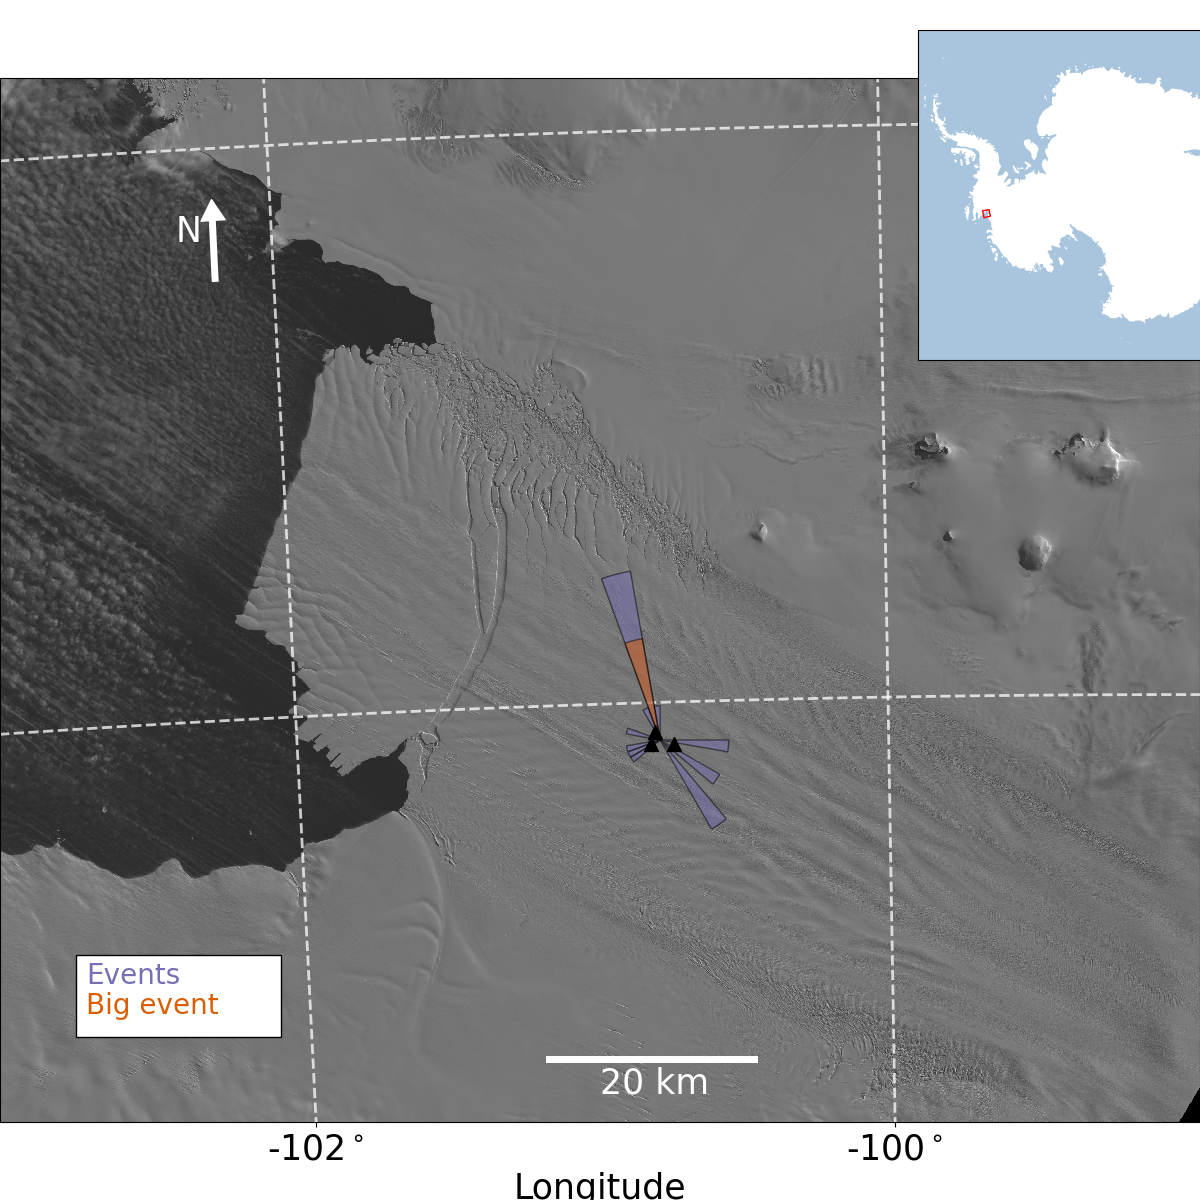

In [12]:
'''

Plot the locations of all the detected events

'''

# load the results of polarization analysis
baz_file = open("outputs/event_backazimuths_PIG2_PIG4_PIG5_distance_pca_fixed_centroid.pickle", "rb")
b = pickle.load(baz_file)
baz_file.close()

# get backazimuths of detected events
backazimuths = b.backazimuths
big_event_backazimuth = backazimuths[12]

# get station locations and array centroids
station_lon_lat_coords = get_station_coordinates("data/XML/")
station_grid_coords = get_station_grid_locations(station_lon_lat_coords,"epsg:3245")
array_centroid = np.mean(station_grid_coords,axis=0)

# open LANDSAT imagery file
file = "data/imagery/LC08_L1GT_001113_20131012_20170429_01_T2_B4.TIF"
transform_imagery(file,'epsg:3245')

# set where to split the distribution and which color to use for each
colors = ["#7570b3","#d95f02"]

# make the figure
plot_catalog_and_big_event_backazimuths(backazimuths,big_event_backazimuth,array_centroid,station_grid_coords,colors)

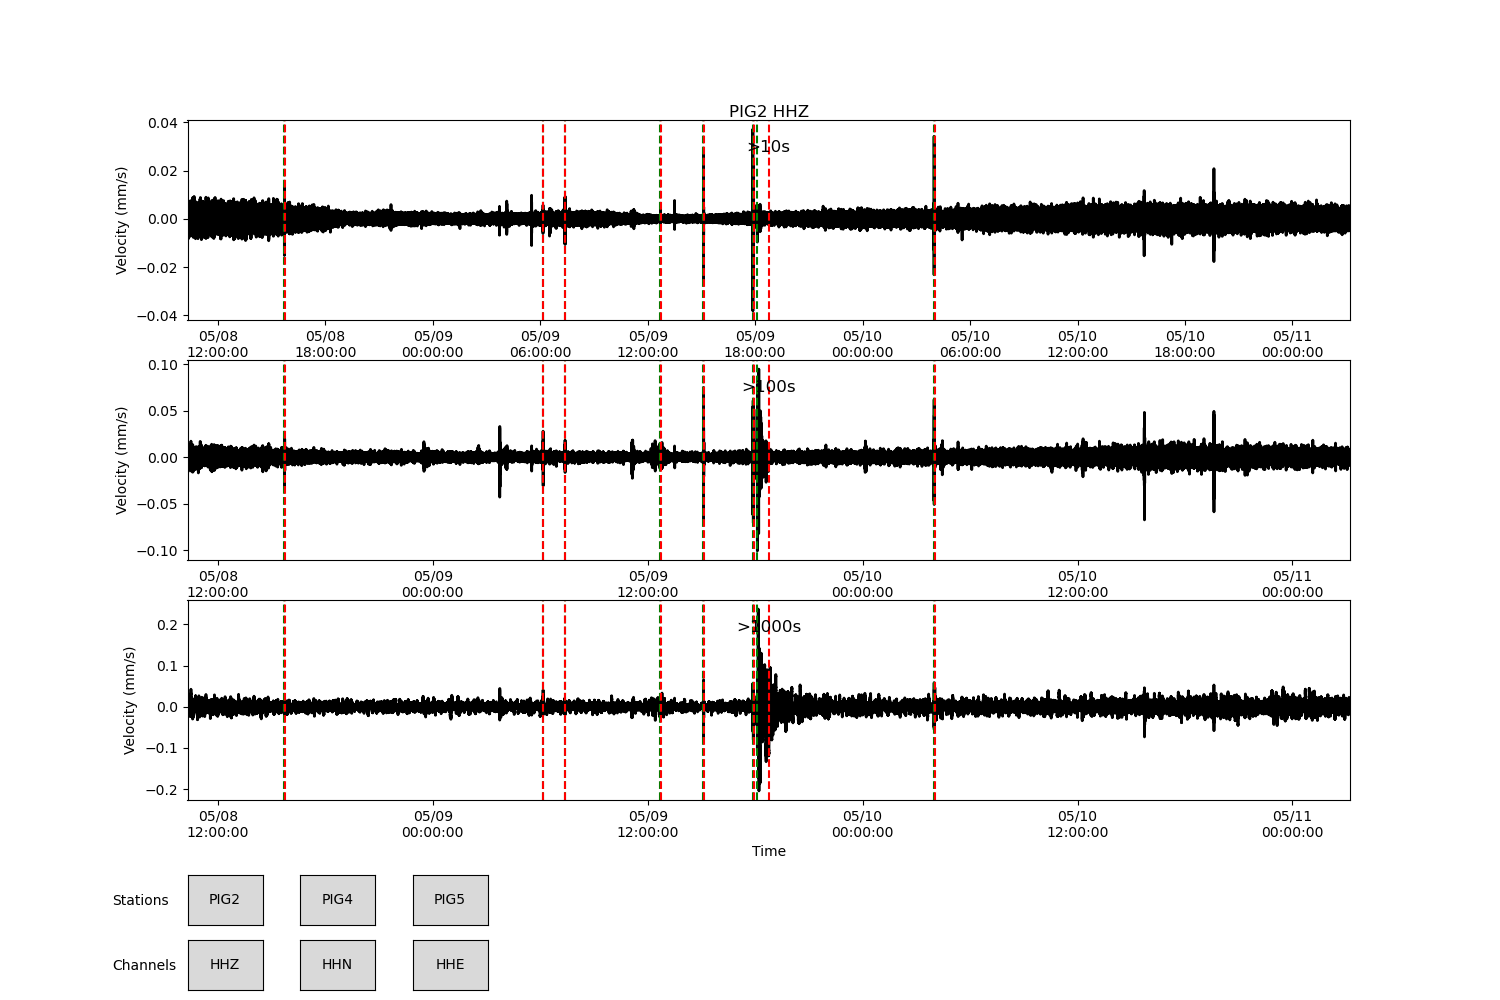

In [13]:
'''

Investigate which events are coming from the azimuthal range of the new rift branch

'''

# load catalog 
detection_times = np.load('outputs/detections.npy',allow_pickle=True)

# read backazimuths
baz_file = open("outputs/event_backazimuths_PIG2_PIG4_PIG5_distance_pca_fixed_centroid.pickle", "rb")
b = pickle.load(baz_file)
baz_file.close()
backazimuths = b.backazimuths

# set range of interest
baz_range = [280,360]

# get data
st_10s = obspy.read("data/MSEED/may_8-11_velocity_10s_downsampled.MSEED")
st_100s = obspy.read("data/MSEED/may_8-11_velocity_100s_downsampled.MSEED")
st_1000s = obspy.read("data/MSEED/may_8-11_velocity_1000s_downsampled.MSEED")

# put data into dictionary
window_start = obspy.UTCDateTime(2012,5,8,10,18)
window_end = obspy.UTCDateTime(2012,5,11,3,13)
data_10s_dict = {}
data_100s_dict = {}
data_1000s_dict = {}
for tr in st_10s:
    key = tr.stats.station+tr.stats.channel
    data_10s_dict[key] = tr.trim(starttime=window_start,endtime=window_end).data*1000
for tr in st_100s:
    key = tr.stats.station+tr.stats.channel
    data_100s_dict[key] = tr.trim(starttime=window_start,endtime=window_end).data*1000
for tr in st_1000s:
    key = tr.stats.station+tr.stats.channel
    data_1000s_dict[key] = tr.trim(starttime=window_start,endtime=window_end).data*1000

# get time vector
t = st_10s[1].times(type="matplotlib")

# define object for updating data when buttons are pressed
class metadata:
    station = "PIG2"
    channel = "HHZ"
    
    def select_channel(self,channel):
        def clicked(event):
            self.channel = channel
            ax[0].get_lines()[0].set_ydata(data_10s_dict[self.station+self.channel])
            ax[1].get_lines()[0].set_ydata(data_100s_dict[self.station+self.channel])
            ax[2].get_lines()[0].set_ydata(data_1000s_dict[self.station+self.channel])
            ax[0].set_title(self.station+" "+self.channel+"\n\n>10s",y=0.8)
            for axis in ax:
                axis.relim()
                axis.autoscale()
                axis.set_xlim([t[0],t[-1]])
            plt.draw()
        return clicked
    
    def select_station(self,station):
        def clicked(event):
            self.station = station
            ax[0].get_lines()[0].set_ydata(data_10s_dict[self.station+self.channel])
            ax[1].get_lines()[0].set_ydata(data_100s_dict[self.station+self.channel])
            ax[2].get_lines()[0].set_ydata(data_1000s_dict[self.station+self.channel])
            ax[0].set_title(self.station+" "+self.channel+"\n\n>10s",y=0.8)
            for axis in ax:
                axis.relim()
                axis.autoscale()
                axis.set_xlim([t[0],t[-1]])
            plt.draw()
        return clicked
    
def mouse_event(event):
    print('x: {} and y: {}'.format(event.xdata, event.ydata))
    
# make plot
fig,ax = plt.subplots(3,1,figsize=[15,10])
plt.subplots_adjust(bottom=0.2)

# plot the data
ax[0].plot(t,data_10s_dict["PIG2HHZ"], lw=2,color='k')
ax[0].set_title("PIG2 HHZ\n\n>10s",y=0.8)
ax[1].plot(t,data_100s_dict["PIG2HHZ"], lw=2,color='k')
ax[1].set_title(">100s",y=0.8)
ax[2].plot(t,data_1000s_dict["PIG2HHZ"], lw=2,color='k')
ax[2].set_title(">1000s",y=0.8)

# make instances of the widget
column0 = metadata()

for axis in ax:
    axis.set_ylabel("Velocity (mm/s)")
    axis.set_xlabel("Time")
    axis.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%H:%M:%S'))
    axis.set_xlim([t[0],t[-1]])
ax[2].get_shared_x_axes().join(ax[2],ax[0])
ax[2].get_shared_x_axes().join(ax[2],ax[1])

# add each set of buttons
axbutton = plt.axes([0.125, 0.075, 0.05, 0.05])
pig2_b0 = Button(axbutton, 'PIG2')
pig2_b0.on_clicked(column0.select_station("PIG2"))
axbutton = plt.axes([0.2, 0.075, 0.05, 0.05])
pig4_b0 = Button(axbutton, 'PIG4')
pig4_b0.on_clicked(column0.select_station("PIG4"))
axbutton = plt.axes([0.275, 0.075, 0.05, 0.05])
pig5_b0 = Button(axbutton, 'PIG5')
pig5_b0.on_clicked(column0.select_station("PIG5"))
plt.text(-4,0.4,"Stations")
axbutton = plt.axes([0.125, 0.01, 0.05, 0.05])
hhz_b0 = Button(axbutton, 'HHZ')
hhz_b0.on_clicked(column0.select_channel("HHZ"))
axbutton = plt.axes([0.2, 0.01, 0.05, 0.05])
hhn_b0 = Button(axbutton, 'HHN')
hhn_b0.on_clicked(column0.select_channel("HHN"))
axbutton = plt.axes([0.275, 0.01, 0.05, 0.05])
hhe_b0 = Button(axbutton, 'HHE')
hhe_b0.on_clicked(column0.select_channel("HHE"))
plt.text(-4,0.4,"Channels")

# highlight events in baz range of interest
for i in range(len(backazimuths)):
    if backazimuths[i] >= baz_range[0] and backazimuths[i] <= baz_range[1]:
        for axis in ax:
            axis.axvline(detection_times[i][0],0,1,color ='g',linestyle='--')
            axis.axvline(detection_times[i][1],0,1,color ='r',linestyle='--')

plt.show()

In [20]:
''' 

Calculate backazimuths for big event on a few frequency bands 

'''

# initialize location parameter object and set parameters for backazimuth computation
l = types.SimpleNamespace()
l.win_len = 50
l.slide = 5
l.stations = ["PIG2","PIG4","PIG5"]
l.network = "XC"

# load and sort catalog
detection_times = np.load('outputs/detections.npy',allow_pickle=True)
sort_indices = np.argsort(detection_times[:,0])
l.detection_times = detection_times[sort_indices][14].reshape(1,2)

# set the coordinate system in which we will do all grid-based calculations
l.crs = "EPSG:3245"

# set signal-to-noise ratio for throwing out stations and sta/lta ratio for throwing out individual windows in backazimuth computation
l.snr_threshold = 0
l.stalta_threshold = 0

# specify method for correcting pca components 
l.pca_correction = "distance"
l.centroid = "fixed"

# specify parameters for cross correlation based determination of station of first arrival
l.max_shift = 1000
freq = [[0.0001,10],[0.001,10],[0.01,10],[0.1,10],[1,10]]
l.fs = 100

# specify paths to data and me tadata
#l.data_path = "data/MSEED/no_IR/"
#l.xml_path = "data/XML/"
l.data_path = "/media/Data/Data/PIG/MSEED/noIR/"
l.xml_path = "/media/Data/Data/PIG/XML/HH/"
l.n_procs = 10

# run the backazimuth code
for f in freq:
    l.freq = f
    l.filename = "outputs/big_event_backazimuth_" + str(f[0]) + "Hz"
    b = compute_backazimuths(l)

    # save the output
    baz_file = open(l.filename + ".pickle", "wb")
    pickle.dump(b, baz_file)
    baz_file.close()

Got all files...

Made inputs...

Finished with 2012-05-09

Got all files...

Made inputs...

Finished with 2012-05-09

Got all files...

Made inputs...

Finished with 2012-05-09

Got all files...

Made inputs...

Finished with 2012-05-09

Got all files...

Made inputs...

Finished with 2012-05-09



/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/cartopy/cr

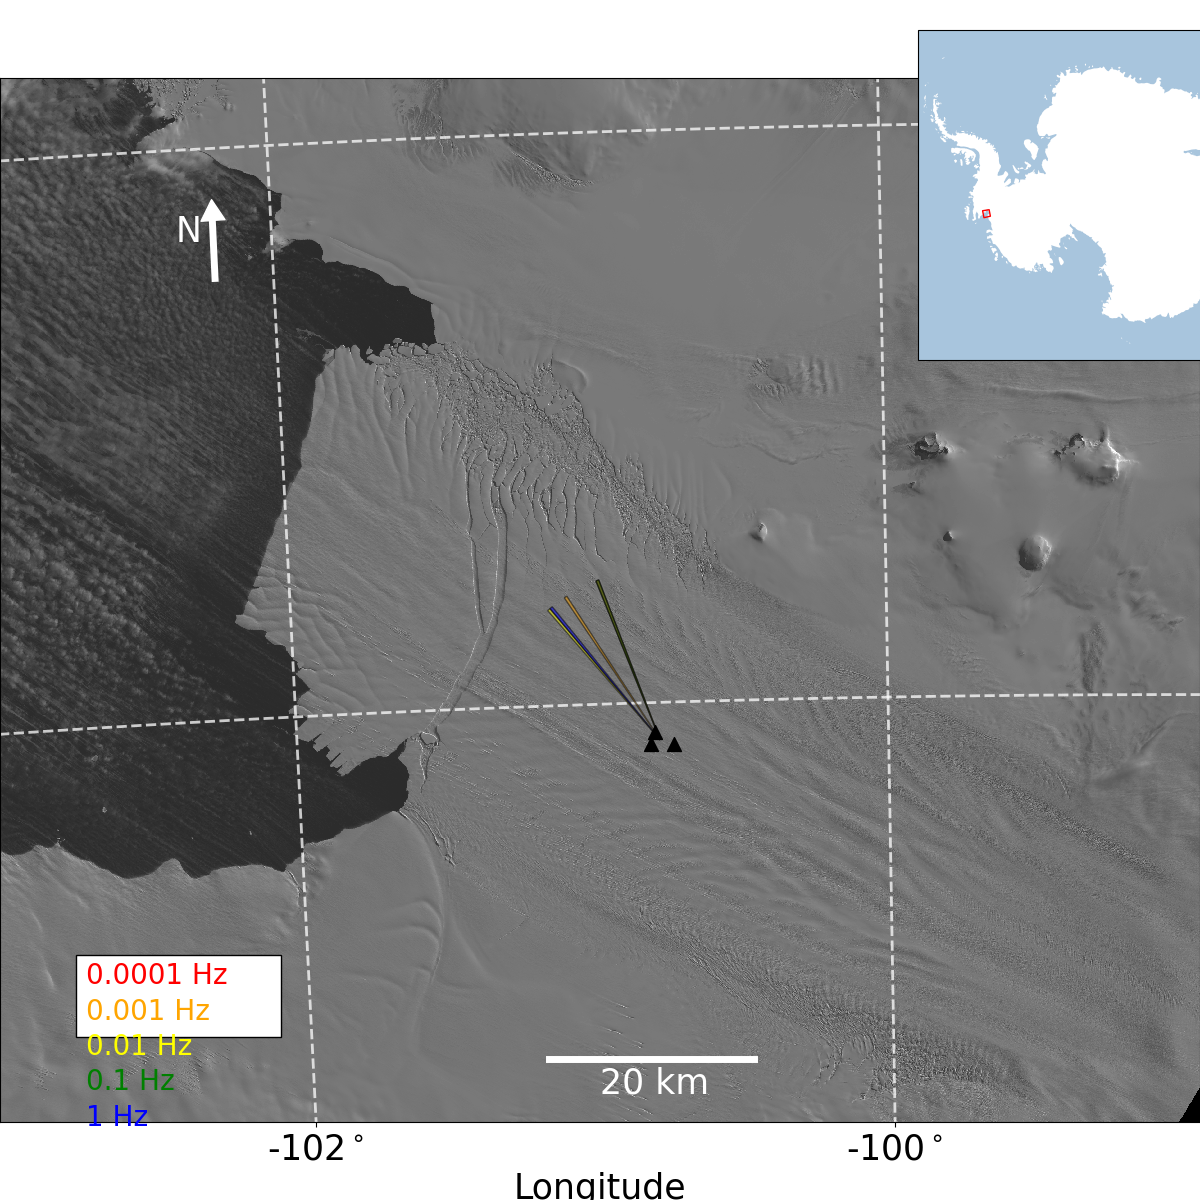

In [2]:
'''

Plot the backazimuths of the big event calculated at a few different frequencies

'''

# load the results of polarization analysis
freq = [0.0001,0.001,0.01,0.1,1]
backazimuths = []
for f in freq:
    baz_file = open("outputs/big_event_backazimuth_"+str(f)+"Hz.pickle", "rb")
    b = pickle.load(baz_file)
    backazimuths.append(b.backazimuths[0])
    baz_file.close()

# get station locations and array centroids
station_lon_lat_coords = get_station_coordinates("data/XML/")
station_grid_coords = get_station_grid_locations(station_lon_lat_coords,"epsg:3245")
array_centroid = np.mean(station_grid_coords,axis=0)

# open LANDSAT imagery file
file = "data/imagery/LC08_L1GT_001113_20131012_20170429_01_T2_B4.TIF"
transform_imagery(file,'epsg:3245')

# set where to split the distribution and which color to use for each
colors = ["red","orange","yellow","green","blue"]

# make the figure
plot_big_event_backazimuths(backazimuths,freq,array_centroid,station_grid_coords,colors)

In [ ]:
'''

Plot backazimuths as a function of frequency

'''

# load the results of polarization analysis
freq = [0.0001,0.001,0.01,0.1,1]
backazimuths = []
for f in freq:
    baz_file = open("outputs/big_event_backazimuth_"+str(f)+"Hz.pickle", "rb")
    b = pickle.load(baz_file)
    backazimuths.append(b.backazimuths)
    baz_file.close()   

fig,ax = plt.subplots()
ax.scatter(freq,backazimuths)
ax.set_xscale('log')
ax.set_xticks([1e-5,1e-4,1e-3,1e-2,1e-1,1])